# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import keras
from keras.metrics import RootMeanSquaredError
from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization, Input
from keras.callbacks import ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

inputs = '/kaggle/input/stock-price-prediction-finprosinterview'

2024-03-25 06:58:47.536045: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 06:58:47.536162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 06:58:47.841150: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Constants & Settings

In [2]:
# Set display options
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', 1000)  # Set display width

# Data

## Loading Data

In [3]:
vic = pd.read_csv(f'{inputs}/VIC.csv')
fpt = pd.read_csv(f'{inputs}/FPT.csv')
pnj = pd.read_csv(f'{inputs}/PNJ.csv')
msn = pd.read_csv(f'{inputs}/MSN.csv')
files = {
    'vic': vic,
    'msn': msn,
    'pnj': pnj,
    'fpt': fpt}

## Overview of the data

In [4]:
vic.head(5)

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,VIC,10/17/2018 9:39,98.5,98.5,98.5,98.5,390,0
1,VIC,10/17/2018 9:40,98.5,98.5,98.5,98.5,760,0
2,VIC,10/17/2018 9:41,98.6,98.6,98.6,98.6,2060,0
3,VIC,10/17/2018 9:42,98.6,98.6,98.6,98.6,5540,0
4,VIC,10/17/2018 9:43,98.6,98.7,98.6,98.7,760,0


In [5]:
vic.info()
vic.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101266 entries, 0 to 101265
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         101266 non-null  object 
 1   Date/Time      101266 non-null  object 
 2   Open           101266 non-null  float64
 3   High           101266 non-null  float64
 4   Low            101266 non-null  float64
 5   Close          101266 non-null  float64
 6   Volume         101266 non-null  int64  
 7   Open Interest  101266 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 6.2+ MB


,Open,High,Low,Close,Volume,Open Interest
count,101266.000000,101266.000000,101266.000000,101266.000000,1.012660e+05,101266.0
mean,105.376460,105.418519,105.334147,105.378791,3.182640e+03,0.0
std,11.543158,11.535584,11.552338,11.545054,1.469814e+04,0.0
min,68.000000,68.000000,68.000000,68.000000,1.000000e+01,0.0
25%,95.400000,95.400000,95.300000,95.400000,2.300000e+02,0.0
50%,105.300000,105.300000,105.200000,105.300000,1.020000e+03,0.0
75%,115.800000,115.900000,115.800000,115.800000,3.000000e+03,0.0
max,126.100000,126.500000,126.100000,126.500000,1.468390e+06,0.0


## Data preprocessing

### Rename columns and Convert date from string to datetime format

In [6]:
# Rename columns
for company, df in files.items():
    df.rename(columns={"Ticker":"ticker","Date/Time":"date","Open":"open","High":"high","Low":"low","Close":"close", "Volume":"volume","Open Interest":"open_interest"}, inplace= True)
    df['date'] = pd.to_datetime(df.date)
    print(f'{company} dataframe after remane and format \n{df.head(3)}')

vic dataframe after remane and format 
  ticker                date  open  high   low  close  volume  open_interest
0    VIC 2018-10-17 09:39:00  98.5  98.5  98.5   98.5     390              0
1    VIC 2018-10-17 09:40:00  98.5  98.5  98.5   98.5     760              0
2    VIC 2018-10-17 09:41:00  98.6  98.6  98.6   98.6    2060              0
msn dataframe after remane and format 
  ticker                date  open  high   low  close  volume  open_interest
0    MSN 2017-12-25 09:15:00  73.1  73.1  73.1   73.1    4210              0
1    MSN 2017-12-25 09:16:00  73.0  73.0  73.0   73.0    5000              0
2    MSN 2017-12-25 09:18:00  73.5  73.5  73.5   73.5     210              0
pnj dataframe after remane and format 
  ticker                date   open   high    low  close  volume  open_interest
0    PNJ 2018-02-28 09:15:00  78.14  78.99  78.14  78.99     270              0
1    PNJ 2018-02-28 09:16:00  78.94  78.94  78.94  78.94      10              0
2    PNJ 2018-02-28 09:19:0

In [7]:
for company, df in files.items():
    print(f"Unique values contained in Column 'open_interest' in {company} dataset: ",df['open_interest'].unique())

Unique values contained in Column 'open_interest' in vic dataset:  [0]
Unique values contained in Column 'open_interest' in msn dataset:  [0]
Unique values contained in Column 'open_interest' in pnj dataset:  [0]
Unique values contained in Column 'open_interest' in fpt dataset:  [0]


We can see that the open interest columns do not have any insight in out datasets

So we can drop it for better view

In [8]:
for company, df in files.items():
    df.drop(columns=['open_interest'], inplace=True)
    print(f"Drop column 'open interest' in {company} dataset.")

Drop column 'open interest' in vic dataset.
Drop column 'open interest' in msn dataset.
Drop column 'open interest' in pnj dataset.
Drop column 'open interest' in fpt dataset.


Make sure there are no duplicates within our datasets

In [9]:
for company, df in files.items():
    df.drop_duplicates(keep=False, inplace=True)
    print(f'Drop duplicates in {company}')

Drop duplicates in vic
Drop duplicates in msn
Drop duplicates in pnj
Drop duplicates in fpt


### Insight

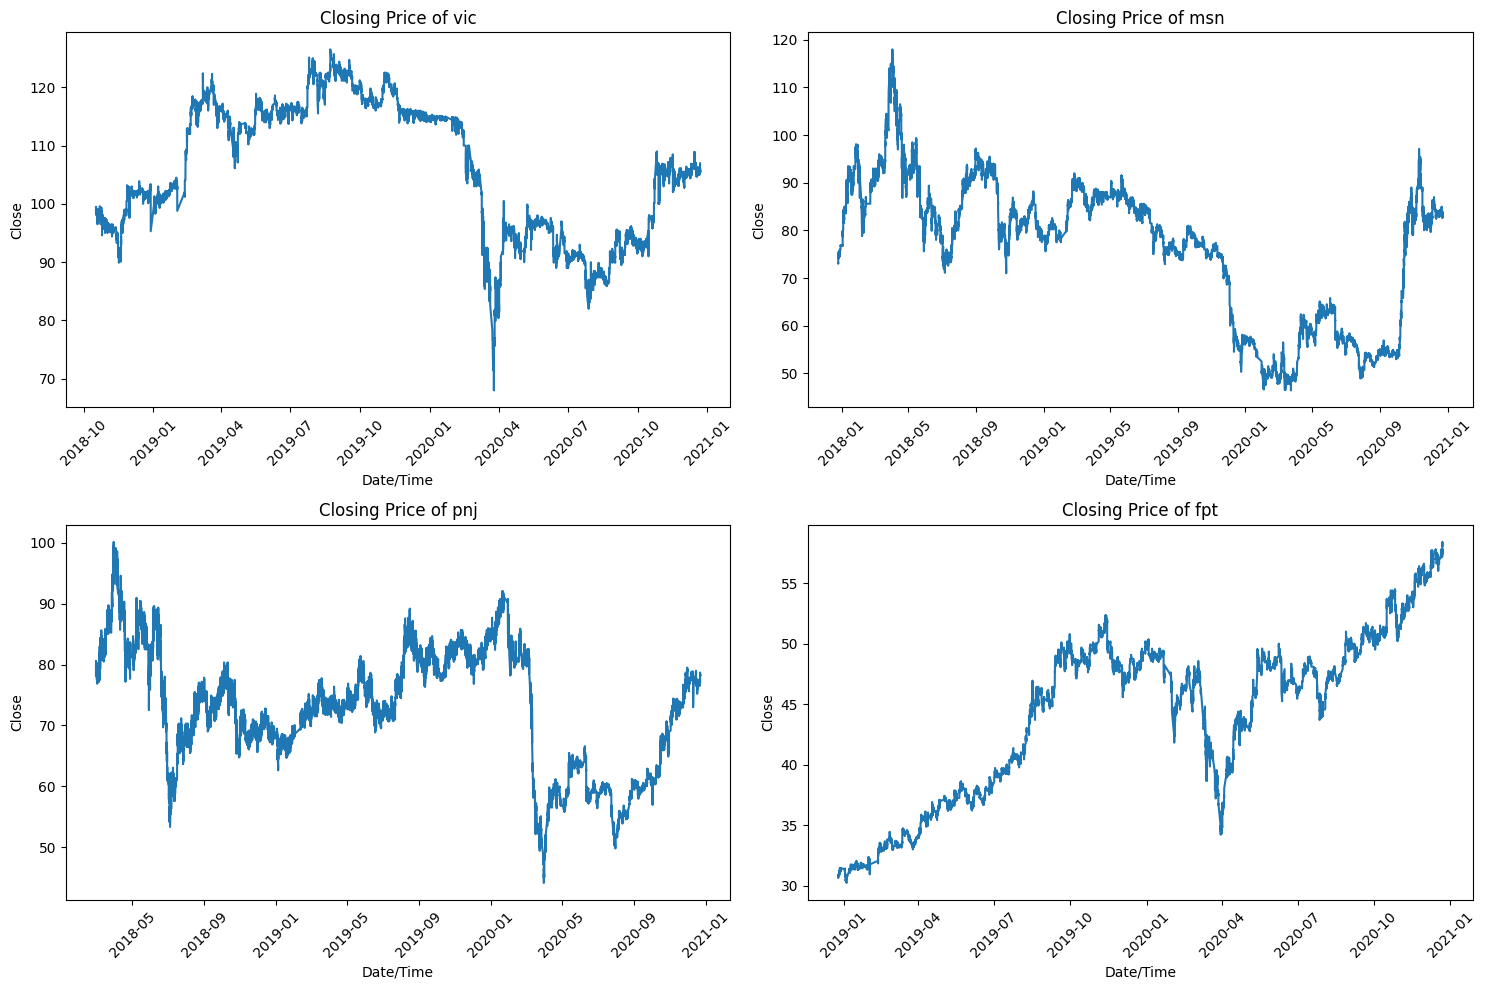

In [10]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, (company, df) in enumerate(files.items(), 1):
    plt.subplot(2, 2, i)
    plt.plot(df['date'], df['close'])
    plt.ylabel('Close')
    plt.xlabel('Date/Time')
    plt.title(f"Closing Price of {company}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Create Statistical Features (Moving Averages) 
Incorporating moving average features into the training process for stock price prediction can provide valuable insights and context about the historical trends and patterns in the data.

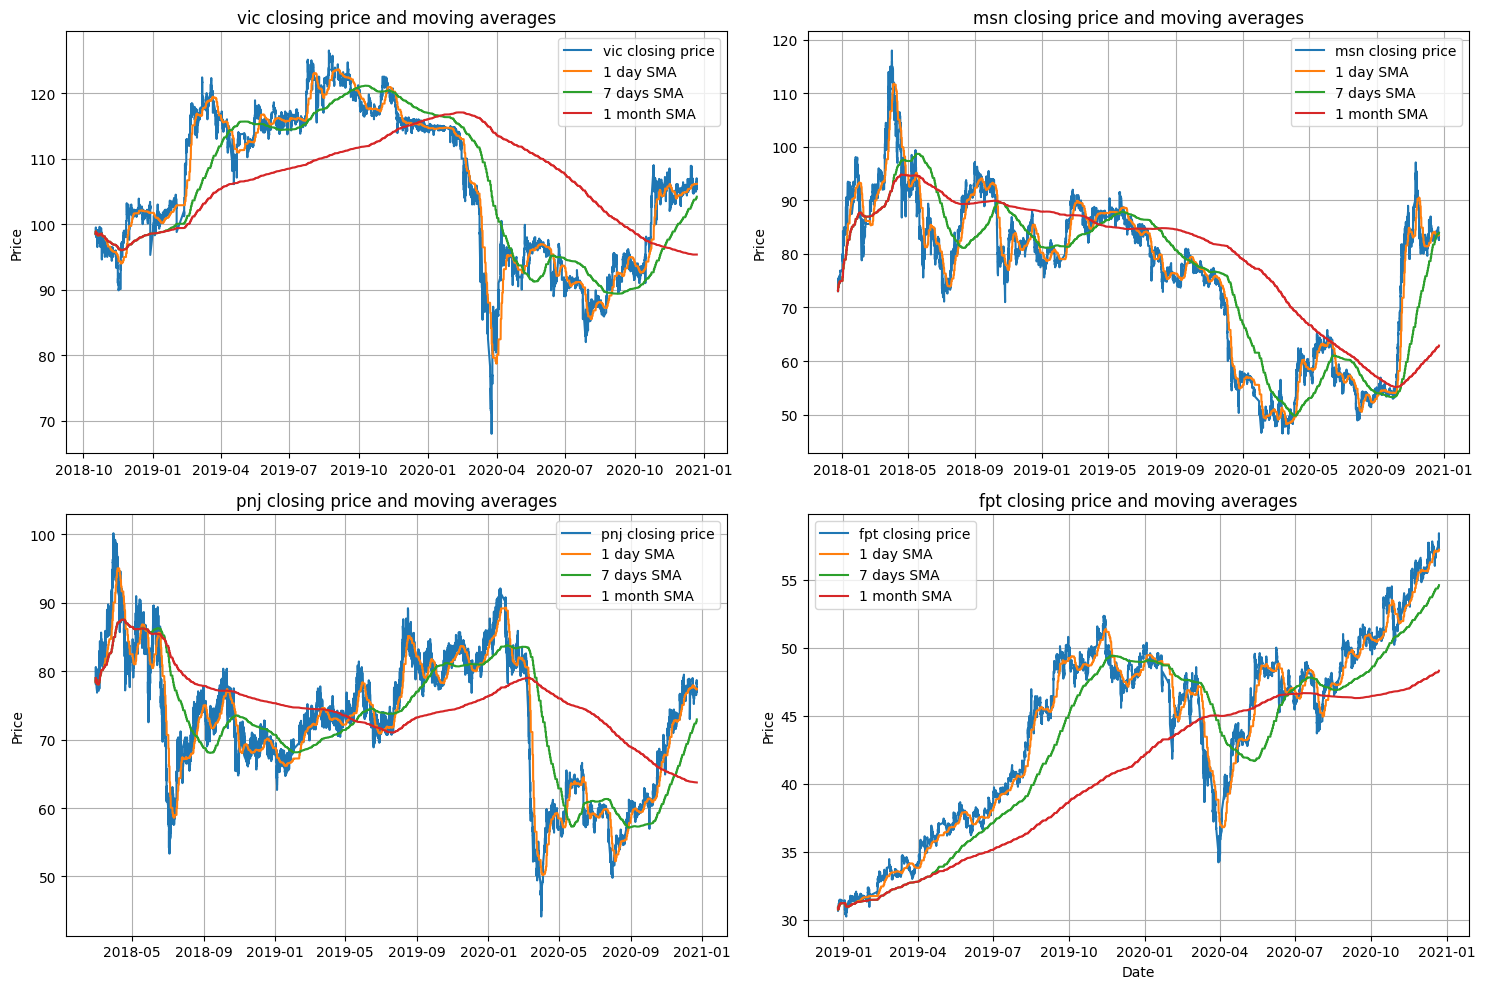

In [11]:
time_periods = [1, 7, 30]  # Moving averages in days
# Create subplots for each company
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(top=1.25, bottom=0.8)

for i, (company, df) in enumerate(files.items(), 1):
    row = (i - 1) // 2
    col = (i - 1) % 2
    ax = axes[row, col]
    
    ax.plot(df['date'], df['close'], label=f'{company} closing price')

    # Plot moving averages for each time period
    for period in time_periods:
        ma = df['close'].rolling(window=period*60*24, min_periods=1).mean()
        label = ''
        if period >= 30:
            if(int(period/30) > 1):
                label = f'{int(period/30)} months SMA'
            else: 
                label = f'{int(period/30)} month SMA'
        else:
            if(period == 1):
                label = f'{period} day SMA'
            else: 
                label = f'{period} days SMA'
        
        df[f'{label}'] = ma
        ax.plot(df['date'], ma, label=label, linestyle='-')

    ax.set_ylabel('Price')
    ax.set_title(f"{company} closing price and moving averages")
    ax.grid(True)
    ax.legend()

ax.set_xlabel('Date')

plt.tight_layout()
plt.show()

### Price Change

Add column and calculates the price change based on the close price of the previous day

In [12]:
for company, df in files.items():
    # Calculate price change based on close price of previous day
    df['price_change'] = df['close'].diff()
    df.loc[0, 'price_change'] = 0

## Scaling and Spliting

**Split** the data into three datasets


1.   Training set 60%
2.   Validation set 20%
3.   Testing set 20%

**Process**

* **Pass in** the *time_series_steps*, *features* to scaling and spliting, which *target* so return the scaler of that target for later inverse transform
1. Loop through 4 dataset, in each dataset i loop through one by one features passed in
2. Scaling that columns (contained inside one tmp dataframe called tmp_df) if the feature is target -> store the scaler according to the company's name for latter inverse transform
3. After loop all the features, create X_data and y_data (time_series_steps)
4. Split the data in 60% train, 20% validate, 20% test
* **Return** X_train, y_train, X_validate, y_validate, X_test, y_test, scalers (test_data must include the name of the company and specific test data)

In [13]:
def create_x_y_lstm_dataset(data, time_series=30):
    X_tmp, y_tmp = [], []
    # print(time_series)
    # print(len(data))
    for i in range(time_series, len(data)):
        X_tmp.append(data[i-time_series:i].reshape(time_series,-1))
        y_tmp.append(data[i,-1])

    return np.array(X_tmp), np.array(y_tmp)

def spliting_data(time_series=50, features=['open', 'low', 'high', 'volume', 'close', 'price_change'], target='price_change'):
    X_train, y_train, X_validate, y_validate = [], [], [], []
    X_test, y_test, scalers = {}, {}, {}

    for company, df in files.items():
        temp_df = df[features].copy()
        for feature in features:
            scaler = MinMaxScaler(feature_range=(0,1))
            temp_df[feature] = scaler.fit_transform(temp_df[feature].values.reshape(-1,1))
            if feature == target:
                scalers[company] = scaler

        X_df, y_df = create_x_y_lstm_dataset(temp_df.values, time_series=time_series)

        train_split = 0.6
        validate_split = 0.8

        train_split_ix = int(np.ceil(len(X_df)*train_split))
        validate_split_ix = int(np.ceil(len(X_df)*validate_split))

        X_train_df, X_validate_df, X_test_df = X_df[:train_split_ix], X_df[train_split_ix:validate_split_ix], X_df[validate_split_ix:]

        y_train_df, y_validate_df, y_test_df = y_df[:train_split_ix], y_df[train_split_ix:validate_split_ix], y_df[validate_split_ix:]

        X_train.append(X_train_df)
        y_train = np.concatenate((y_train,y_train_df))

        X_validate.append(X_validate_df)
        y_validate = np.concatenate((y_validate,y_validate_df))

        X_test[company] = X_test_df
        y_test[company] = y_test_df

    X_train = np.vstack(X_train)
    y_train = np.array(y_train)

    X_validate = np.vstack(X_validate)
    y_validate = np.array(y_validate)

    return X_train, y_train, X_validate, y_validate, X_test, y_test, scalers

### Spliting data

In [14]:
features= []

for fet in files['vic'].columns[2:]:
    features.append(fet)

In [15]:
X_train, y_train, X_validate, y_validate, X_test, y_test, scalers = spliting_data(30, features, target='price_change')

In [16]:
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_validate: {X_validate.shape}')
print(f'y_validate: {y_validate.shape}')

X_train: (275531, 30, 9)
y_train: (275531,)
X_validate: (91843, 30, 9)
y_validate: (91843,)


# Model
Since stock prices prediction is essentially a regression problem, the RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error %) will be our current model evaluation metrics. Both are useful measures of forecast accuracy.

## LSTM model

Since stock prices prediction is essentially a regression problem. Therefore, the

* MSE (Mean Squared Error)

* RMSE (Root Mean Squared Error)

will be my current model evaluation metrics. Which are useful measures of forecast accuracy.

In [17]:
metrics = [RootMeanSquaredError()]
opt = keras.optimizers.Adam(learning_rate=0.01)
callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                patience=2, min_lr=0.000001, verbose=1)]

**LSTM architecture**

I will train two different LSTM model architectures and choose the best one based on the predicting results latter

In [18]:
# Define the model architecture
def create_model_1(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(64, return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(32, return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(16, return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(8))
    model.add(Dense(1))
    return model

def create_model_2(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(100, return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(50, return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(50))
    model.add(Dense(1))
    return model

In [19]:
sample_model1 = create_model_1(input_shape=(X_train.shape[1], X_train.shape[2]))
sample_model1.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=0.01),
                metrics=metrics)

# Display the model summary
sample_model1.summary()

sample_model2 = create_model_2(input_shape=(X_train.shape[1], X_train.shape[2]))
sample_model2.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=0.01),
                metrics=metrics)

# Display the model summary
sample_model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 16)         │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,753 (139.66 KB)

 Trainable params: 35,529 (138.79 KB)

 Non-trainable params: 224 (896.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 100)        │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 30, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 30, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30, 50)         │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,051 (371.29 KB)

 Trainable params: 94,751 (370.12 KB)

 Non-trainable params: 300 (1.17 KB)

### Fine Tunning number of layers and batch_sizes

Prepare list of models and hists to store different version of batch_sizes used to train LSTM model

In [20]:
epochs = [10]
batch_sizes = [64, 128, 256]
hists = {
    'LSTM1_batch64': {},
    'LSTM1_batch128': {},
    'LSTM1_batch256': {},
    'LSTM2_batch64': {},
    'LSTM2_batch128': {},
    'LSTM2_batch256': {},
}
models = {
    'LSTM1_batch64': {},
    'LSTM1_batch128': {},
    'LSTM1_batch256': {},
    'LSTM2_batch64': {},
    'LSTM2_batch128': {},
    'LSTM2_batch256': {},
}

# Fit Model

In [21]:
def plot_metrics(hists, metrics=['loss','root_mean_squared_error']):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']  # List of colors for plotting
    
    for metric in metrics:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Creating subplots with 1 row and 2 columns
        for i, (label, hist) in enumerate(hists.items()):
            color = colors[i % len(colors)]  # Cycle through colors
            axes[0].plot(hist.history[metric], label=f'{label} Train', linestyle='solid', color=color)
            axes[0].set_title(f'Model {metric}')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel(metric)
            axes[0].legend()

            axes[1].plot(hist.history[f'val_{metric}'], label=f'{label} Validation', linestyle='dashed', color=color)
            axes[1].set_title(f'Model {metric} Validation')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel(metric)
            axes[1].legend()

        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()

Train the model with different type of batch_size

In [22]:
# Store your model creation functions in a dictionary
model_creators = {
    1: create_model_1,
    2: create_model_2
}

In [23]:
for i in range(1,3):
    for bs in batch_sizes:
        model_creator = model_creators[i]
        model = model_creator(input_shape=(X_train.shape[1], X_train.shape[2]))
        model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=metrics)

        hists[f'LSTM{i}_batch{bs}'] =  model.fit(X_train, y_train, validation_data=[X_validate, y_validate],
                    epochs=10, batch_size=bs, verbose=1, callbacks=[callbacks])
        models[f'LSTM{i}_batch{bs}'] = model


Epoch 1/10
4306/4306 ━━━━━━━━━━━━━━━━━━━━ 59s 12ms/step - loss: 0.0035 - root_mean_squared_error: 0.0528 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0743 - learning_rate: 0.0100
Epoch 2/10
4306/4306 ━━━━━━━━━━━━━━━━━━━━ 51s 12ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0988 - learning_rate: 0.0100
Epoch 3/10
4306/4306 ━━━━━━━━━━━━━━━━━━━━ 52s 12ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 8.2188e-04 - val_root_mean_squared_error: 0.0287 - learning_rate: 0.0100
Epoch 4/10
4306/4306 ━━━━━━━━━━━━━━━━━━━━ 52s 12ms/step - loss: 0.0015 - root_mean_squared_error: 0.0385 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0330 - learning_rate: 0.0100
Epoch 5/10
4305/4306 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
4306/4306 ━━━━━━━━━━━━━━━━━━━━ 52s 12ms/step - loss: 0.0014 - root_mean_

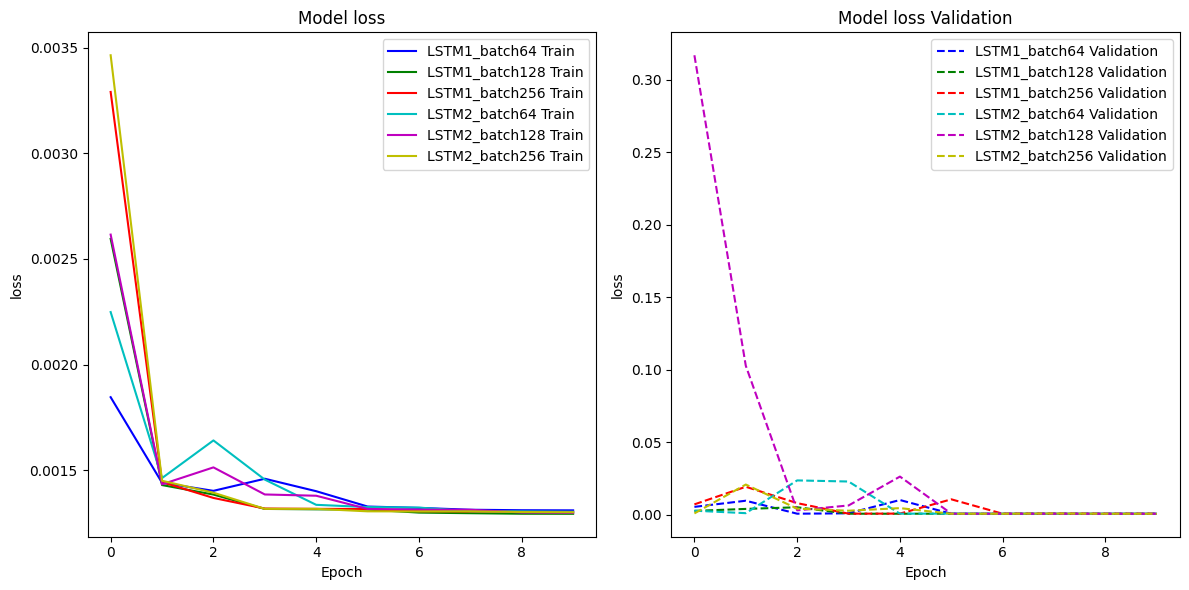

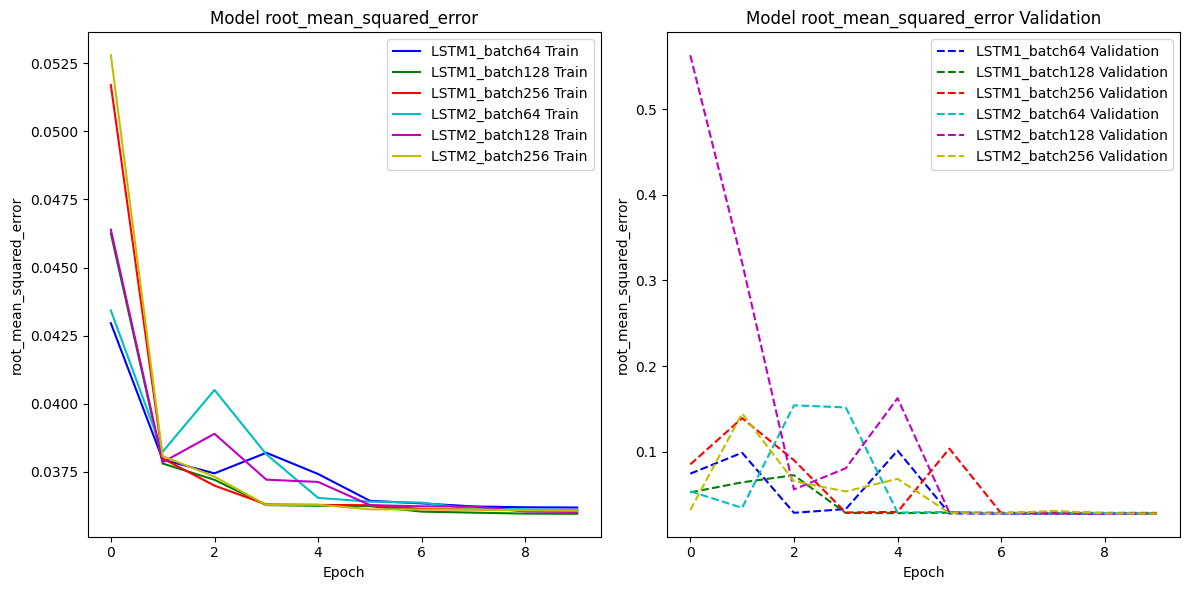

In [24]:
plot_metrics(hists)

**Results**

At the beginning there are huge fluctuations between models' metrics; However, in the long run, they demostrate slightly differences in MSE and RMSE metrics.

Nevertheless, these numbers are scalled so they're not actually show the real performance of the models.

# Predict

In [25]:
# predict on each company
def make_prediction(model, scalers, X_test, y_test):
    y_predict = {}
    y_original = {}
    for company, _ in files.items():
        y_pred = model.predict(X_test[company])

        y_predict[company] = scalers[company].inverse_transform(y_pred.reshape(-1,1))
        y_original[company] = scalers[company].inverse_transform(y_test[company].reshape(-1,1))

    return y_original, y_predict

Create list of predictions for each model

In [26]:
y_original = {}
y_predict = {
    'LSTM1_batch64': {},
    'LSTM1_batch128': {},
    'LSTM1_batch256': {},
    'LSTM2_batch64': {},
    'LSTM2_batch128': {},
    'LSTM2_batch256': {},
}

Make predictions on different LSTM models and store the results for latter analysis.

In [27]:
for pre in y_predict:
    y_original, y_predict[pre] = make_prediction(models[pre], scalers, X_test, y_test)

633/633 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
846/846 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
783/783 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
609/609 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
633/633 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
846/846 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
783/783 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
609/609 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
633/633 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
846/846 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
783/783 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
609/609 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
633/633 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
846/846 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
783/783 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
609/609 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
633/633 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
846/846 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
783/783 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
609/609 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
633/633 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
846/846 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
783/783 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
609/609 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


# Evaluate Model

In [28]:
def evaluate_performance(y_original, y_predict):
    rmses, mses, maes, avgs = [],[],[],[]
    for name, _ in files.items():
        
        rmses.append(math.sqrt(mean_squared_error(y_original[name],y_predict[name])))
        mses.append(mean_squared_error(y_original[name],y_predict[name]))
        maes.append(mean_absolute_error(y_original[name],y_predict[name]))
        avgs.append((rmses[-1] + mses[-1] + maes[-1]) / 3)
        
        print(f'Evaluation metrices RMSE, MSE and MAE for {name}')
        print("RMSE: ", rmses[-1])
        print("MSE: ", mses[-1])
        print("MAE: ", maes[-1])
        print("Average Error", avgs[-1])
        print("-----------------------------------")
        
    return sum(rmses)/len(rmses), sum(mses)/len(mses), sum(maes)/len(maes), sum(avgs)/len(avgs)

def plot_original_vs_predicted(y_original, y_predict):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    for i, (company, df) in enumerate(files.items()):
        row = i // 2
        col = i % 2

        axs[row, col].plot(df['date'], df['close'], color='#90D26D', label='Close', linewidth=1)
        axs[row, col].plot(df['date'], df['close_predict'], color='#8B93FF', label='Close Predict', linewidth=0.5)
        axs[row, col].set_title(f'{company} Close vs Close Predict')
        axs[row, col].set_xlabel('Date')
        axs[row, col].set_ylabel('Price')
        axs[row, col].legend()

    plt.tight_layout()
    plt.show()


List of results of each model

In [29]:
results = {
    'LSTM1_batch64': {},
    'LSTM1_batch128': {},
    'LSTM1_batch256': {},
    'LSTM2_batch64': {},
    'LSTM2_batch128': {},
    'LSTM2_batch256': {},
    'LinearRegression': {},
    'XGBRegressor': {},
}

In [30]:
for m in hists:
    results[m]['rmse'],results[m]['mse'],results[m]['mae'],results[m]['avg'] = evaluate_performance(y_original, y_predict[m])

Evaluation metrices RMSE, MSE and MAE for vic
RMSE:  0.1947323192130049
MSE:  0.037920676146075645
MAE:  0.10579398383434317
Average Error 0.11281565973114123
-----------------------------------
Evaluation metrices RMSE, MSE and MAE for msn
RMSE:  0.25600513540656
MSE:  0.06553862935453111
MAE:  0.13067209656239234
Average Error 0.15073862044116115
-----------------------------------
Evaluation metrices RMSE, MSE and MAE for pnj
RMSE:  0.17228572765622685
MSE:  0.029682371954035565
MAE:  0.12031985023152178
Average Error 0.10742931661392807
-----------------------------------
Evaluation metrices RMSE, MSE and MAE for fpt
RMSE:  0.06988620043441886
MSE:  0.004884081011159767
MAE:  0.04487496963572748
Average Error 0.03988175036043537
-----------------------------------
Evaluation metrices RMSE, MSE and MAE for vic
RMSE:  0.19992664001537608
MSE:  0.03997066138783778
MAE:  0.11935664773627302
Average Error 0.11975131637982896
-----------------------------------
Evaluation metrices RMSE, 

Add price_change_predict and close_predict columns for plotting

In [31]:
for company, df in files.items():
    start = y_original[company].shape[0]
    predicted_values = y_predict[f'LSTM1_batch64'][company][-start:]
    df['price_change_predict'] = pd.Series(predicted_values.flatten(), index=df.index[-start:])
    df['close_predict'] = df['close'] + df['price_change_predict']

Drawing the chart of prediction result on test data (20%) which haven't been seen by the models we trainned before.

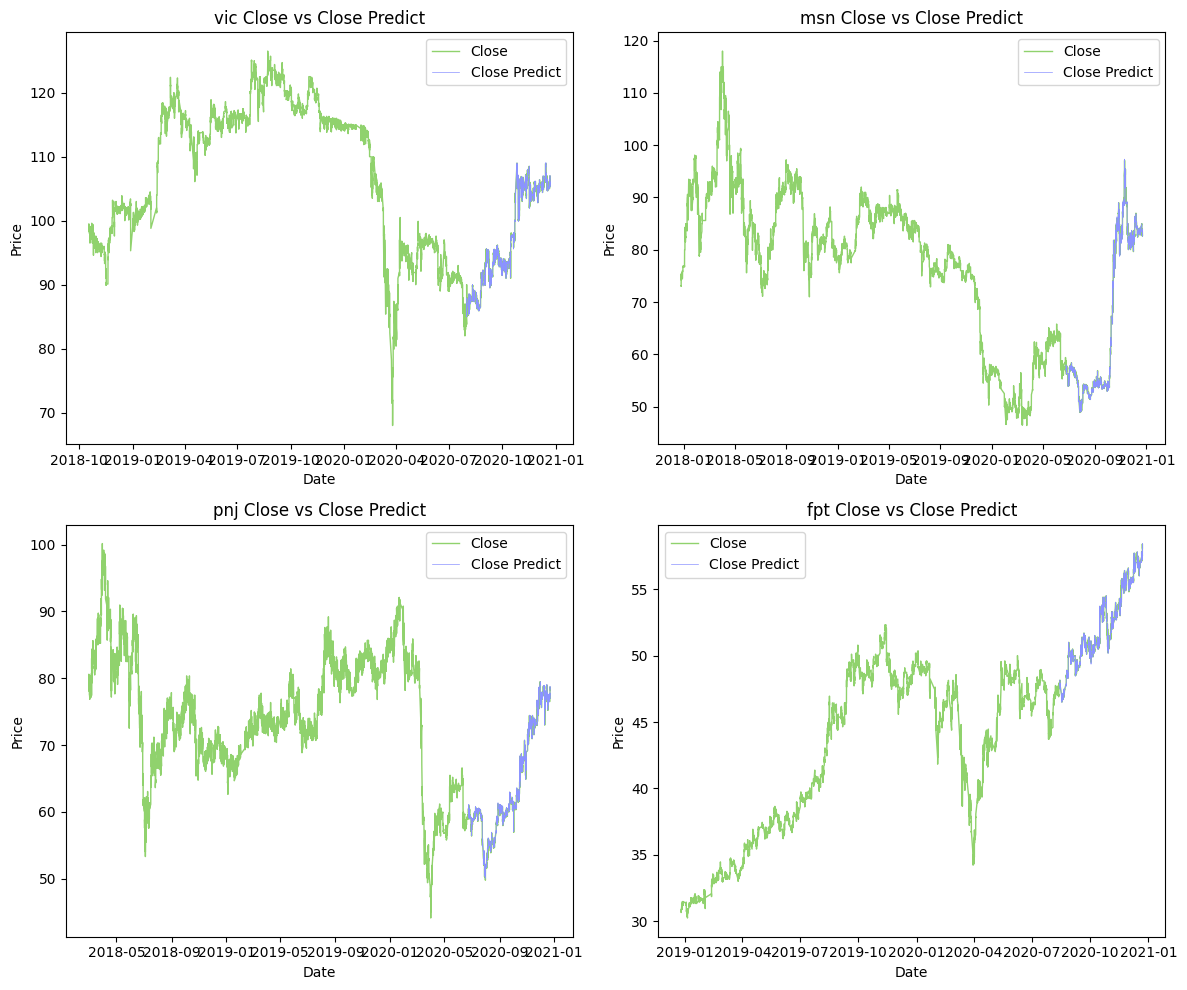

In [32]:
plot_original_vs_predicted(y_original, y_predict)

**It shows that the LSTM model's predictions are pretty fit with the actual data which is unseen.**

# Other Approachs

I also make comparision on built-in machine learning models, which are widely-used for regression tasks

* **LinearRegression** is a simple and widely-used linear model for regression tasks. It assumes a linear relationship between the input features and the target variable.

* **XGBRegressor** is a regression model based on gradient boosting, a powerful ensemble learning technique.

In [33]:
regressors = {
    'LinearRegression': LinearRegression(),
    'XGBRegressor': XGBRegressor(),
}

In [34]:
X_train_regress = X_train.reshape(X_train.shape[0], -1)

X_test_regress = X_test
y_test_regress = y_test

for name, df in files.items():
    X_test_regress[name] = X_test_regress[name].reshape(X_test_regress[name].shape[0], -1)
    y_test_regress[name] = y_test_regress[name].reshape(y_test_regress[name].shape[0], -1)

In [35]:
for name, reg in regressors.items():
    print(name)
    
    reg.fit(X_train_regress, y_train)

    y_original, y_predict = {}, {}
    y_original, y_predict = make_prediction(reg, scalers, X_test_regress, y_test_regress)
    
    results[name]['rmse'],results[name]['mse'],results[name]['mae'],results[name]['avg'] = evaluate_performance(y_original, y_predict)
    print('-'*80)

LinearRegression
Evaluation metrices RMSE, MSE and MAE for vic
RMSE:  0.2181194982176949
MSE:  0.04757611550273901
MAE:  0.12745334145210693
Average Error 0.1310496517241803
-----------------------------------
Evaluation metrices RMSE, MSE and MAE for msn
RMSE:  0.24535369574323013
MSE:  0.060198436014861544
MAE:  0.13777032150752513
Average Error 0.14777415108853895
-----------------------------------
Evaluation metrices RMSE, MSE and MAE for pnj
RMSE:  0.15064752870408904
MSE:  0.022694677904649335
MAE:  0.08918588485811949
Average Error 0.08750936382228595
-----------------------------------
Evaluation metrices RMSE, MSE and MAE for fpt
RMSE:  0.07365371828081681
MSE:  0.0054248702165899275
MAE:  0.050274924427513
Average Error 0.04311783764163991
-----------------------------------
--------------------------------------------------------------------------------
XGBRegressor
Evaluation metrices RMSE, MSE and MAE for vic
RMSE:  0.2030503091805245
MSE:  0.04122942805830659
MAE:  0.109

In [37]:
# Sort the results based on the 'avg' value
sorted_results = sorted(results.items(), key=lambda x: x[1]['avg'])

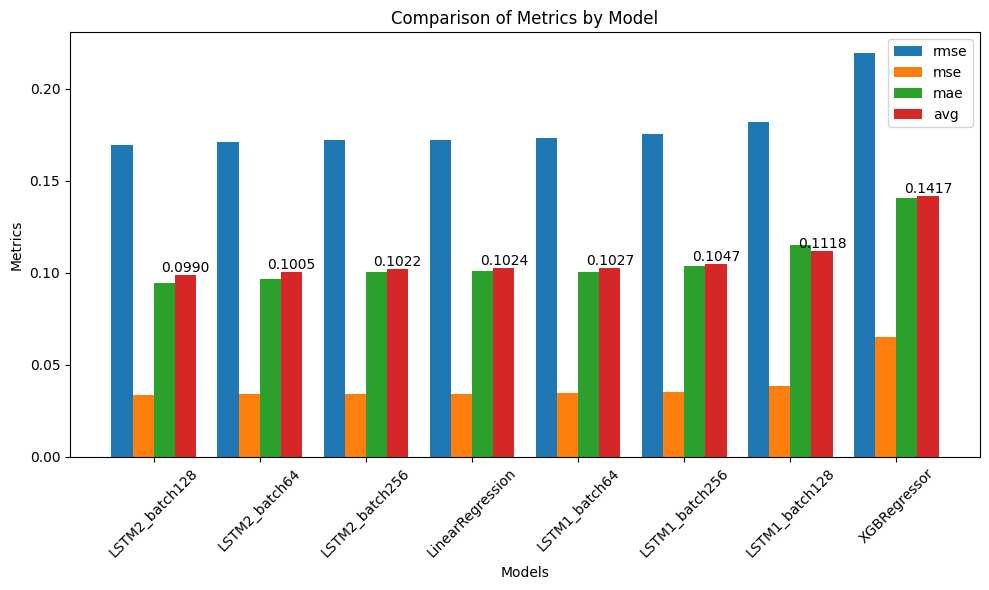

In [38]:
sorted_results_dict = dict(sorted_results)

reg_models = list(sorted_results_dict.keys())
metrics = ['rmse', 'mse', 'mae', 'avg']
metric_values = {metric: [sorted_results_dict[model][metric] for model in reg_models] for metric in metrics}

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
for i, (metric, values) in enumerate(metric_values.items()):
    x = range(len(reg_models))
    x_adjusted = [pos + i * bar_width for pos in x]
    bars = ax.bar(x_adjusted, values, bar_width, label=metric)
    
    if metric == 'avg':
        for bar, value in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.4f}', ha='center', va='bottom')

# Setting labels and ticks
ax.set_xlabel('Models')
ax.set_ylabel('Metrics')
ax.set_title('Comparison of Metrics by Model')
ax.set_xticks([pos + 1.5 * bar_width for pos in range(len(reg_models))])
ax.set_xticklabels(reg_models)
ax.legend()

plt.xticks(rotation=45) 

plt.tight_layout()
plt.show()


# Conclusion

* Though the differences are not outstanding, LSTM models (both LSTM1 and LSTM2) perform competitively when compared to traditional regression-based models like Linear Regression and XGBoost Regressor. 

* LSTM2 has the best performance: time_series_steps = 30, batch_size = 128, epochs = 10.
* I might choose the LSTM model as it demonstrates the best performance in terms of prediction accuracy.